In [2]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [69]:
all_data = loadmat('data/sample_1.mat')
sample_data = np.array(all_data['data'])
spike_times = np.array(all_data['spike_times'])

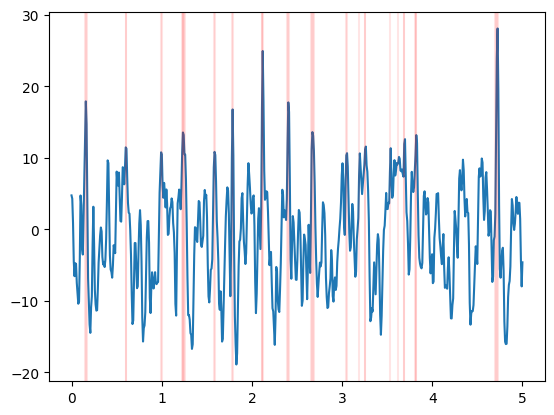

In [70]:
seconds = 5
data = sample_data[0][:seconds*120]
plt.plot(np.linspace(0, seconds, seconds*120), data)
for spike in np.where(data > 10)[0]:
    plt.axvline(spike/120, c='red', alpha=0.1)
plt.show()